# Predicci√≥n de la Incidencia del dengue en Regiones del Per√∫ usando Machine Learning


In [ ]:
import pandas as pd

df_dengue = pd.read_csv('https://raw.githubusercontent.com/galuf/dengueML/refs/heads/main/datos_abiertos_vigilancia_dengue_2000_2023.csv')

In [ ]:
df_dengue.columns

Index(['departamento', 'provincia', 'distrito', 'enfermedad', 'ano', 'semana',
       'diagnostic', 'tipo_dx', 'diresa', 'ubigeo', 'edad', 'tipo_edad',
       'sexo'],
      dtype='object')

In [ ]:
df_dengue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757890 entries, 0 to 757889
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   departamento  757890 non-null  object 
 1   provincia     757890 non-null  object 
 2   distrito      757890 non-null  object 
 3   enfermedad    757890 non-null  object 
 4   ano           757890 non-null  int64  
 5   semana        757890 non-null  int64  
 6   diagnostic    757890 non-null  object 
 7   tipo_dx       757890 non-null  object 
 8   diresa        757867 non-null  float64
 9   ubigeo        757890 non-null  int64  
 10  edad          757890 non-null  int64  
 11  tipo_edad     757890 non-null  object 
 12  sexo          757890 non-null  object 
dtypes: float64(1), int64(4), object(8)
memory usage: 75.2+ MB


In [ ]:
df_dengue.shape

(757890, 13)

In [ ]:
df_dengue_raw= df_dengue.copy()

In [ ]:
df_dengue_raw  = df_dengue_raw.drop(columns=['enfermedad', 'diagnostic', 'tipo_dx', 'tipo_edad', 'sexo', 'edad','diresa','ubigeo'], axis=1)

## Generaci√≥n de macro regiones

In [ ]:
# ============================================================
# 3. MACRO-REGIONES / SUB-REGIONES
# === CAMBIO === Crear variable epidemiol√≥gica √∫til
# ============================================================
def map_macro_region(dep):
    dep = dep.upper()
    costa_norte = {'TUMBES', 'PIURA', 'LAMBAYEQUE', 'LA LIBERTAD'}
    costa_norte_chico = {'ANCASH', 'LIMA', 'CALLAO'}
    selva = {'LORETO', 'UCAYALI', 'SAN MARTIN', 'MADRE DE DIOS', 'AMAZONAS'}
    if dep in costa_norte: return 'costa_norte'
    if dep in costa_norte_chico: return 'costa_norte_chico'
    if dep in selva: return 'selva'
    return 'otras'

df_dengue_raw['macro_region'] = df_dengue_raw['departamento'].map(map_macro_region)

In [ ]:
df_dengue_raw =  df_dengue_raw[df_dengue_raw['macro_region'] != 'otras']

In [ ]:
df_dengue_raw

departamento         provincia     distrito   ano  semana macro_region
18          UCAYALI  CORONEL PORTILLO  YARINACOCHA  2000      51        selva
37      LA LIBERTAD          TRUJILLO  EL PORVENIR  2000      22  costa_norte
38      LA LIBERTAD          TRUJILLO  EL PORVENIR  2000      26  costa_norte
39      LA LIBERTAD          TRUJILLO  EL PORVENIR  2000      30  costa_norte
40      LA LIBERTAD          TRUJILLO     TRUJILLO  2000      24  costa_norte
...             ...               ...          ...   ...     ...          ...
757885       TUMBES            TUMBES       TUMBES  2023      52  costa_norte
757886       TUMBES            TUMBES       TUMBES  2023      52  costa_norte
757887       TUMBES            TUMBES       TUMBES  2023      52  costa_norte
757888       TUMBES            TUMBES       TUMBES  2023      52  costa_norte
757889       TUMBES            TUMBES       TUMBES  2023      52  costa_norte

[632430 rows x 6 columns]

In [ ]:
anios = ['2019','2020','2021','2022','2023']
df_last = []
for anio in anios:
    url = f'https://raw.githubusercontent.com/galuf/dengueML/refs/heads/main/{anio}/{anio}.csv'
    df_year = pd.read_csv(url)
    df_year = df_year.rename(columns={
        'MAX': 'tem_max',
        'MIN': 'tem_min'
    })
    df_last.append(df_year)

df_last_years = pd.concat(df_last, ignore_index=True)

## Union de datos SENAMHI

In [ ]:
import pandas as pd

# Lista para almacenar cada mes
dfs = []

# Leer archivos de enero (01) a diciembre (12)
for mes in range(1, 13):
    url = f'https://github.com/galuf/dengueML/raw/main/2018/senamhi_data_completo2018{mes:02d}.xlsx'
    df = pd.read_excel(url)
    # Renombrar si existen esas columnas
    df = df.rename(columns={
        'TEMPERATURA (¬∞C)': 'tem_max',
        'TEMPERATURA (¬∞C).1': 'tem_min'
    })

    dfs.append(df)

# Unir todos los DataFrames
df_all = pd.concat(dfs, ignore_index=True)

# Mostrar las primeras filas
display(df_all.head())
del df_all['fecha_consulta']
del df_all['codigo']


A√ëO / MES / D√çA tem_max tem_min HUMEDAD RELATIVA (%) PRECIPITACI√ìN (mm/d√≠a)  \
0      2018-01-01    21.8       2                 75.9                    0.0   
1      2018-01-02      24      .4                 68.0                    0.0   
2      2018-01-03    23.6     3.8                 71.6                    0.0   
3      2018-01-04    20.4     5.6                 87.5                    6.5   
4      2018-01-05    20.6     8.6                 83.0                   19.2   

     estacion  codigo      lat       lon ico  fecha_consulta departamento  \
0  BAMBAMARCA  100015 -6.67655 -78.51834   M          201801    Cajamarca   
1  BAMBAMARCA  100015 -6.67655 -78.51834   M          201801    Cajamarca   
2  BAMBAMARCA  100015 -6.67655 -78.51834   M          201801    Cajamarca   
3  BAMBAMARCA  100015 -6.67655 -78.51834   M          201801    Cajamarca   
4  BAMBAMARCA  100015 -6.67655 -78.51834   M          201801    Cajamarca   

   provincia    distrito  
0  Hualgayoc  Bambamarca  
1  Hualgayoc  Bambamarca  
2  Hualgayoc  Bambamarca  
3  Hualgayoc  Bambamarca  
4  Hualgayoc  Bambamarca

In [ ]:
# Unir todos los DataFrames
df_f = pd.concat([df_all, df_last_years], ignore_index=True)

# Mostrar las primeras filas
display(df_f.head())

A√ëO / MES / D√çA tem_max tem_min HUMEDAD RELATIVA (%) PRECIPITACI√ìN (mm/d√≠a)  \
0      2018-01-01    21.8       2                 75.9                    0.0   
1      2018-01-02      24      .4                 68.0                    0.0   
2      2018-01-03    23.6     3.8                 71.6                    0.0   
3      2018-01-04    20.4     5.6                 87.5                    6.5   
4      2018-01-05    20.6     8.6                 83.0                   19.2   

     estacion      lat       lon ico departamento  provincia    distrito  
0  BAMBAMARCA -6.67655 -78.51834   M    Cajamarca  Hualgayoc  Bambamarca  
1  BAMBAMARCA -6.67655 -78.51834   M    Cajamarca  Hualgayoc  Bambamarca  
2  BAMBAMARCA -6.67655 -78.51834   M    Cajamarca  Hualgayoc  Bambamarca  
3  BAMBAMARCA -6.67655 -78.51834   M    Cajamarca  Hualgayoc  Bambamarca  
4  BAMBAMARCA -6.67655 -78.51834   M    Cajamarca  Hualgayoc  Bambamarca

## Limpieza de datos

In [ ]:
# Aseg√∫rate de que la columna 'fecha' est√© bien creada y no tenga nulos
df_f['fecha'] = pd.to_datetime(df_f['A√ëO / MES / D√çA'], errors='coerce')
df_f = df_f.dropna(subset=['fecha'])

# Convert columns to numeric, coercing errors
for col in ['tem_max', 'tem_min', 'HUMEDAD RELATIVA (%)', 'PRECIPITACI√ìN (mm/d√≠a)']:
    df_f[col] = pd.to_numeric(df_f[col], errors='coerce')


# Extraer a√±o y semana ISO
df_f['ano'] = df_f['fecha'].dt.year
df_f['semana'] = df_f['fecha'].dt.isocalendar().week

# Agrupar por a√±o, semana, departamento, provincia, distrito
df_semana = df_f.groupby(
    ['ano', 'semana', 'departamento', 'provincia', 'distrito']
)[['tem_max', 'tem_min', 'HUMEDAD RELATIVA (%)', 'PRECIPITACI√ìN (mm/d√≠a)']].mean().reset_index()

# Mostrar primeras filas
display(df_semana.head())

ano  semana departamento    provincia      distrito  tem_max  tem_min  \
0  2018       1     Amazonas        Bagua      Aramango  33.5000  18.9125   
1  2018       1     Amazonas  Chachapoyas   Chachapoyas  19.6750   9.8250   
2  2018       1     Amazonas    Utcubamba  Bagua Grande  33.1500  23.1250   
3  2018       1     Amazonas    Utcubamba       Jamalca  25.9000  17.9500   
4  2018       1       Ancash         Aija          Aija  15.8875   1.6625   

   HUMEDAD RELATIVA (%)  PRECIPITACI√ìN (mm/d√≠a)  
0               79.3000                  0.4000  
1               80.5375                  3.0750  
2               91.6625                  0.3625  
3               96.1125                  5.4000  
4               80.1750                  2.0875

## Union de datos CEPLAN

In [ ]:
df_altitud = pd.read_csv('https://raw.githubusercontent.com/galuf/dengueML/refs/heads/main/altitud_distritos_peru.csv')
df_altitud.head()

departamento    provincia     distrito  ubigeo_inei  ubigeo_reniec  \
0     AMAZONAS  CHACHAPOYAS  CHACHAPOYAS      10101.0        10101.0   
1     AMAZONAS  CHACHAPOYAS     ASUNCION      10102.0        10102.0   
2     AMAZONAS  CHACHAPOYAS       BALSAS      10103.0        10103.0   
3     AMAZONAS  CHACHAPOYAS        CHETO      10104.0        10104.0   
4     AMAZONAS  CHACHAPOYAS    CHILIQUIN      10105.0        10105.0   

   altitud_msnm   latitud   longitud  
0        2338.0 -6.229444 -77.872778  
1        2823.0 -6.032500 -77.710833  
2         859.0 -6.835833 -78.019722  
3        2143.0 -6.255556 -77.700833  
4        2677.0 -6.078333 -77.737500

In [ ]:
df_altitud.drop(columns=['ubigeo_inei','ubigeo_reniec','latitud','longitud'], inplace=True)

In [ ]:
df_altitud.head()

departamento    provincia     distrito  altitud_msnm
0     AMAZONAS  CHACHAPOYAS  CHACHAPOYAS        2338.0
1     AMAZONAS  CHACHAPOYAS     ASUNCION        2823.0
2     AMAZONAS  CHACHAPOYAS       BALSAS         859.0
3     AMAZONAS  CHACHAPOYAS        CHETO        2143.0
4     AMAZONAS  CHACHAPOYAS    CHILIQUIN        2677.0

## Union de datos COVID

In [ ]:
df_covid = pd.read_csv("https://raw.githubusercontent.com/galuf/dengueML/refs/heads/main/Datos_covid.csv",sep=';')


In [ ]:
cols_texto = ['departamento', 'provincia', 'distrito']

for col in cols_texto:
    df_dengue_raw[col] = df_dengue_raw[col].str.upper().str.strip()
    df_semana[col] = df_semana[col].str.upper().str.strip()
    df_altitud[col] = df_altitud[col].str.upper().str.strip()
    df_covid[col] = df_covid[col].str.upper().str.strip()

## Union de datos ONI

In [ ]:
df_oni =pd.read_csv('https://raw.githubusercontent.com/galuf/dengueML/refs/heads/main/ONI.csv')
df_oni

Anio  Mes  TOTAL  ClimAdjust  ANOM
0   2018    1  25.57       26.55 -0.98
1   2018    2  25.98       26.76 -0.78
2   2018    3  26.50       27.29 -0.80
3   2018    4  27.32       27.83 -0.51
4   2018    5  27.74       27.94 -0.20
..   ...  ...    ...         ...   ...
79  2024    8  26.74       26.86 -0.12
80  2024    9  26.46       26.72 -0.26
81  2024   10  26.45       26.72 -0.27
82  2024   11  26.46       26.70 -0.25
83  2024   12  26.00       26.60 -0.60

[84 rows x 5 columns]

In [ ]:
# Paso 1: Merge con semana para filtrar
df_dengue_stg = df_dengue_raw.merge(
    df_semana,
    on=['ano', 'semana', 'departamento', 'provincia', 'distrito'],
    how='inner'
).merge(
    df_altitud,
    on=['departamento', 'provincia', 'distrito'],
    how='left'
)

# Create a 'date' column to extract the month
df_dengue_stg['date'] = pd.to_datetime(df_dengue_stg['ano'].astype(str) + '-W' + df_dengue_stg['semana'].astype(str) + '-1', format='%Y-W%W-%w')
df_dengue_stg['Mes'] = df_dengue_stg['date'].dt.month

# Merge with df_oni
df_dengue_stg = df_dengue_stg.merge(
    df_oni,
    left_on=['ano', 'Mes'],
    right_on=['Anio', 'Mes'],
    how='left'
)

df_covid_clean = df_covid.drop_duplicates(subset=['ano', 'semana', 'departamento', 'provincia', 'distrito'])

# Paso 2: Solo a√±adir flag_covid sin reescribir todo
df_dengue_anl = df_dengue_stg.merge(
    df_covid_clean[['ano', 'semana', 'departamento', 'provincia', 'distrito', 'flag_covid']],
    on=['ano', 'semana', 'departamento', 'provincia', 'distrito'],
    how='left'  # ‚úÖ Mantenemos todas las filas del DataFrame con clima
)
df_dengue_anl['flag_covid'] = df_dengue_anl['flag_covid'].fillna(0)

# Drop the temporary 'date', 'Mes', and 'Anio' columns from df_dengue_anl
df_dengue_anl = df_dengue_anl.drop(columns=['date'])

In [ ]:
df_dengue_anl.isnull().sum()

departamento                  0
provincia                     0
distrito                      0
ano                           0
semana                        0
macro_region                  0
tem_max                   11931
tem_min                   12527
HUMEDAD RELATIVA (%)      16963
PRECIPITACI√ìN (mm/d√≠a)    15067
altitud_msnm                  0
Mes                           0
Anio                          0
TOTAL                         0
ClimAdjust                    0
ANOM                          0
flag_covid                    0
dtype: int64

In [ ]:
df_dengue_anl.isnull().sum()

departamento                  0
provincia                     0
distrito                      0
ano                           0
semana                        0
macro_region                  0
tem_max                   11931
tem_min                   12527
HUMEDAD RELATIVA (%)      16963
PRECIPITACI√ìN (mm/d√≠a)    15067
altitud_msnm                  0
Mes                           0
Anio                          0
TOTAL                         0
ClimAdjust                    0
ANOM                          0
flag_covid                    0
dtype: int64

In [ ]:
df_dengue_anl.isnull().sum()

departamento                  0
provincia                     0
distrito                      0
ano                           0
semana                        0
macro_region                  0
tem_max                   11931
tem_min                   12527
HUMEDAD RELATIVA (%)      16963
PRECIPITACI√ìN (mm/d√≠a)    15067
altitud_msnm                  0
Mes                           0
Anio                          0
TOTAL                         0
ClimAdjust                    0
ANOM                          0
flag_covid                    0
dtype: int64

In [ ]:
df_dengue_anl.shape

(88162, 17)

In [ ]:
df_dengue_anl.isnull().sum()

departamento                  0
provincia                     0
distrito                      0
ano                           0
semana                        0
macro_region                  0
tem_max                   11931
tem_min                   12527
HUMEDAD RELATIVA (%)      16963
PRECIPITACI√ìN (mm/d√≠a)    15067
altitud_msnm                  0
Mes                           0
Anio                          0
TOTAL                         0
ClimAdjust                    0
ANOM                          0
flag_covid                    0
dtype: int64

In [ ]:
df_dengue_anl.drop(columns=['departamento','provincia','distrito'], inplace=True)

## Transformaciones finales del dataset pre entrenamiento

In [ ]:
from scipy.stats import mode

df_macro_sem_dengue = (
    df_dengue_anl
      .groupby(['macro_region','ano','semana'])
      .agg(
          total_casos   = ('macro_region', 'size'),
          precip_mean   = ('PRECIPITACI√ìN (mm/d√≠a)', 'mean'),
          temp_max_mean = ('tem_max', 'mean'),
          temp_min_mean = ('tem_min', 'mean'),
          hum_mean      = ('HUMEDAD RELATIVA (%)', 'mean'),
          oni_mean      = ('ANOM', 'mean'),
          climadjust_mean = ('ClimAdjust', 'mean'),
          total_mean = ('TOTAL', 'mean'),
          altitud_mean  = ('altitud_msnm', 'mean'), # Include altitud_mean here
         flag_covid_mod = ('flag_covid', lambda x: mode(x, keepdims=True).mode[0])
      )
      .reset_index()
)

In [ ]:
df_macro_sem_dengue

macro_region   ano  semana  total_casos  precip_mean  temp_max_mean  \
0    costa_norte  2018       1            4     0.000000      30.600000   
1    costa_norte  2018       2            2     0.685714      34.135714   
2    costa_norte  2018       3            1     0.000000      35.285714   
3    costa_norte  2018       4            2     0.000000      36.371429   
4    costa_norte  2018       5            3     0.000000      33.857143   
..           ...   ...     ...          ...          ...            ...   
676        selva  2023      48          149     0.410225      27.888762   
677        selva  2023      49          152    -9.508708      28.569423   
678        selva  2023      50          164    -0.341685      26.612448   
679        selva  2023      51          156    -1.464474      28.267472   
680        selva  2023      52          165     2.761474      26.470642   

     temp_min_mean   hum_mean  oni_mean  climadjust_mean  total_mean  \
0        23.400000  83.000000     -0.98            26.55       25.57   
1        20.264286  70.357143     -0.98            26.55       25.57   
2        19.871429  63.885714     -0.98            26.55       25.57   
3        20.685714  72.000000     -0.98            26.55       25.57   
4        21.657143  70.980952     -0.98            26.55       25.57   
..             ...        ...       ...              ...         ...   
676      19.440800  86.461860      2.02            26.70       28.72   
677      20.634044  88.548783      2.02            26.60       28.63   
678      20.352851  87.348210      2.02            26.60       28.63   
679      20.402966  85.925072      2.02            26.60       28.63   
680      19.480578  89.021479      2.02            26.60       28.63   

     altitud_mean  flag_covid_mod  
0        9.000000             0.0  
1      105.000000             0.0  
2       35.000000             0.0  
3      135.000000             0.0  
4       53.000000             0.0  
..            ...             ...  
676    584.906040             0.0  
677    580.388158             0.0  
678    415.207317             0.0  
679    490.923077             0.0  
680    498.284848             1.0  

[681 rows x 13 columns]

In [ ]:
# Print data types and non-null counts
df_macro_sem_dengue.info()

# Calculate and print missing values
print("\nMissing values per column:")
print(df_macro_sem_dengue.isnull().sum())

# Generate and print summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
print(df_macro_sem_dengue.describe())

# Generate and print summary statistics for object columns
print("\nSummary statistics for object columns:")
print(df_macro_sem_dengue.describe(include='object'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   macro_region     681 non-null    object 
 1   ano              681 non-null    int64  
 2   semana           681 non-null    int64  
 3   total_casos      681 non-null    int64  
 4   precip_mean      653 non-null    float64
 5   temp_max_mean    631 non-null    float64
 6   temp_min_mean    629 non-null    float64
 7   hum_mean         603 non-null    float64
 8   oni_mean         681 non-null    float64
 9   climadjust_mean  681 non-null    float64
 10  total_mean       681 non-null    float64
 11  altitud_mean     681 non-null    float64
 12  flag_covid_mod   681 non-null    float64
dtypes: float64(9), int64(3), object(1)
memory usage: 69.3+ KB

Missing values per column:
macro_region        0
ano                 0
semana              0
total_casos         0
precip_mean        28
temp

In [ ]:
df = df_macro_sem_dengue.copy()

## Entrenamiento en modelos

In [ ]:
# Classification Project: Sonar rocks or mines

# Load libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df.macro_region.value_counts()

macro_region
selva                313
costa_norte          265
costa_norte_chico    103
Name: count, dtype: int64

In [ ]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# 1) Carga y feature engineering temporal
#df = pd.read_csv('/content/df__dengue_delivery.csv')

# Variables c√≠clicas de semana
df['sin_sem'] = np.sin(2*np.pi*df['semana']/52)
df['cos_sem'] = np.cos(2*np.pi*df['semana']/52)

# Lags de casos (1‚Äì4 semanas)
for lag in range(1,5):
    df[f'lag_{lag}'] = df['total_casos'].shift(lag)

# Rolling mean 4 semanas
df['roll_4'] = df['total_casos'].rolling(4).mean()

# Eliminar filas con NaN de lags/rolling
df = df.dropna().reset_index(drop=True)

# 2) Definir X, y
num_feats = [
    'ano','semana','sin_sem','cos_sem',
    'precip_mean','temp_max_mean','temp_min_mean','hum_mean','altitud_mean',
    'lag_1','lag_2','lag_3','lag_4','roll_4','flag_covid_mod','oni_mean','total_mean','climadjust_mean'
]
cat_feats = ['macro_region']
X = df[num_feats + cat_feats]
y = df['total_casos']

# 3) Split temporal 70/30 SIN shuffle sobre los disponibles hasta sem39 de 2023
avail = df[(df['ano']<2023) | ((df['ano']==2023)&(df['semana']<=39))]
hold = df[(df['ano']==2023)&(df['semana']>=40)]

X_av, y_av   = avail[num_feats+cat_feats], avail['total_casos']
X_hold, y_hold = hold[num_feats+cat_feats], hold['total_casos']

X_train, X_test, y_train, y_test = train_test_split(
    X_av, y_av,
    test_size=0.3,
    shuffle=False  # importante: sin shuffle
)

# 4) Pipeline de preprocesamiento
pre = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 5) Validaci√≥n por TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# 6) RandomizedSearchCV ligero
param_dist = {
    'model__n_estimators': [100,200,300],
    'model__max_depth'   : [5,10,15],
    'model__min_samples_leaf': [1,2,4]
}
pipe = Pipeline([
    ('prep', pre),
    ('model', RandomForestRegressor(random_state=7))
])
search = RandomizedSearchCV(
    pipe, param_dist,
    n_iter=5,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=7,
    n_jobs=1
)
search.fit(X_train, y_train)
best = search.best_estimator_

# 7) M√©tricas
def report(name, X, y):
    p = best.predict(X)
    rmse = np.sqrt(mean_squared_error(y, p))
    r2   = r2_score(y, p)
    print(f"{name}: RMSE={rmse:.2f}, R¬≤={r2:.4f}")

print("\n‚Äì‚Äì Evaluaci√≥n ‚Äì‚Äì")
report("Test 30% disponible", X_test, y_test)
report("Hold‚Äëout Q4 2023",   X_hold, y_hold)



‚Äì‚Äì Evaluaci√≥n ‚Äì‚Äì
Test 30% disponible: RMSE=44.16, R¬≤=0.8350
Hold‚Äëout Q4 2023: RMSE=38.31, R¬≤=0.7754


ano  semana   sin_sem   cos_sem  precip_mean  temp_max_mean  \
0  2023      40 -0.992709  0.120537     0.220346      28.949089   
1  2023      41 -0.970942  0.239316     0.288168      28.133301   
2  2023      42 -0.935016  0.354605     0.000123      29.705687   
3  2023      43 -0.885456  0.464723     0.117494      28.381012   
4  2023      44 -0.822984  0.568065     0.000000      28.520049   
5  2023      45 -0.748511  0.663123     0.000000      28.303061   
6  2023      46 -0.663123  0.748511   -11.058873      27.260643   
7  2023      47 -0.568065  0.822984     0.000000      28.717310   
8  2023      48 -0.464723  0.885456     0.000294      29.253339   
9  2023      49 -0.354605  0.935016     0.026029      28.444574   

   temp_min_mean   hum_mean  altitud_mean  lag_1  ...  lag_4  roll_4  \
0      20.048098  79.647920    100.299419  377.0  ...  579.0  401.75   
1      19.620053  80.683213     64.308370  344.0  ...  503.0  332.75   
2      20.149822  78.789101     74.717300  227.0  ...  383.0  296.25   
3      19.563159  79.125499    100.797927  237.0  ...  377.0  250.25   
4      18.467211  79.223345     99.322581  193.0  ...  344.0  203.00   
5      18.537100  78.642857    106.041420  155.0  ...  227.0  188.50   
6      18.268310  78.901871    154.250000  169.0  ...  237.0  159.25   
7      18.521476  75.417857    153.550000  120.0  ...  193.0  141.00   
8      18.815585  76.096773    126.414474  120.0  ...  155.0  140.25   
9      18.721282  77.017433    161.118110  152.0  ...  169.0  129.75   

   flag_covid_mod  oni_mean  total_mean  climadjust_mean  macro_region  \
0             0.0      1.72       28.44            26.72   costa_norte   
1             0.0      1.72       28.44            26.72   costa_norte   
2             0.0      1.72       28.44            26.72   costa_norte   
3             0.0      1.72       28.44            26.72   costa_norte   
4             0.0      1.72       28.44            26.72   costa_norte   
5             0.0      2.02       28.72            26.70   costa_norte   
6             0.0      2.02       28.72            26.70   costa_norte   
7             1.0      2.02       28.72            26.70   costa_norte   
8             0.0      2.02       28.72            26.70   costa_norte   
9             0.0      2.02       28.63            26.60   costa_norte   

   actual   predicted  week_start  
0     344  398.185923  2023-10-01  
1     227  372.654178  2023-10-08  
2     237  252.839350  2023-10-15  
3     193  255.070615  2023-10-22  
4     155  205.420889  2023-10-29  
5     169  145.535030  2023-11-05  
6     120  183.580485  2023-11-12  
7     120  113.828394  2023-11-19  
8     152  121.077273  2023-11-26  
9     127  137.794275  2023-12-03  

[10 rows x 22 columns]

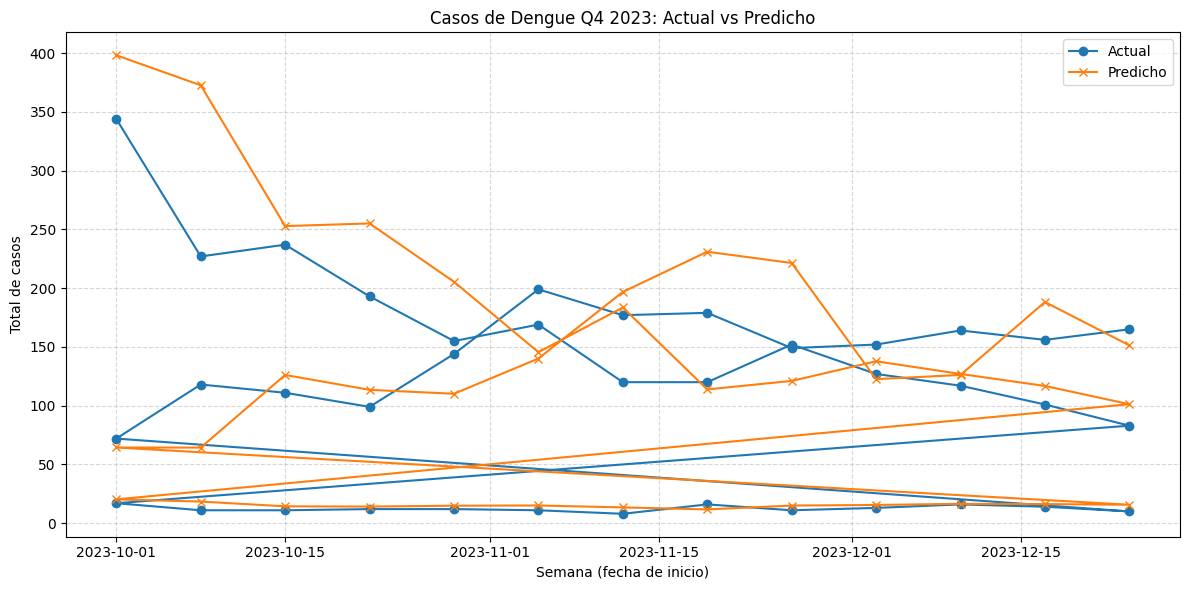

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# ‚Äî‚Äî‚Äî Supuestos:
#   * 'best' es tu pipeline RandomForest/XGBoost ya entrenado
#   * X_hold y y_hold contienen tus features y target del Q4 2023

# 1. Genera predicciones
pred_hold = best.predict(X_hold)

# 2. Construye el DataFrame
df_hold_pred = X_hold.copy().reset_index(drop=True)
df_hold_pred['actual']    = y_hold.reset_index(drop=True)
df_hold_pred['predicted'] = pred_hold

# (Si tienes 'ano' y 'semana' en X_hold)
df_hold_pred['week_start'] = (
    pd.to_datetime(df_hold_pred['ano'], format='%Y') +
    pd.to_timedelta((df_hold_pred['semana'] - 1) * 7, unit='D')
)

# 3. Muestra la tabla
display(df_hold_pred.head(10))   # o sin head() para ver todo

# 4. Gr√°fico de tendencia
plt.figure(figsize=(12,6))
plt.plot(df_hold_pred['week_start'], df_hold_pred['actual'],    label='Actual',    marker='o')
plt.plot(df_hold_pred['week_start'], df_hold_pred['predicted'], label='Predicho', marker='x')
plt.title('Casos de Dengue Q4 2023: Actual vs Predicho')
plt.xlabel('Semana (fecha de inicio)')
plt.ylabel('Total de casos')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
X_train

ano  semana       sin_sem   cos_sem  precip_mean  temp_max_mean  \
0    2018       5  5.680647e-01  0.822984     0.000000      33.857143   
1    2018       6  6.631227e-01  0.748511     0.125000      34.542857   
2    2018       7  7.485107e-01  0.663123     1.380000      34.701429   
3    2018       8  8.229839e-01  0.568065     0.042857      31.914286   
4    2018       9  8.854560e-01  0.464723     0.000000      34.828571   
..    ...     ...           ...       ...          ...            ...   
413  2020      24  2.393157e-01 -0.970942    16.116883      27.565584   
414  2020      25  1.205367e-01 -0.992709     5.406122      24.526327   
415  2020      26 -3.216245e-16 -1.000000     7.505102      19.900255   
416  2020      27 -1.205367e-01 -0.992709    17.379762      18.688155   
417  2020      28 -2.393157e-01 -0.970942    12.359524      19.865629   

     temp_min_mean   hum_mean  altitud_mean  lag_1  lag_2  lag_3  lag_4  \
0        21.657143  70.980952     53.000000    2.0    1.0    2.0    4.0   
1        22.335714  67.525000     56.750000    3.0    2.0    1.0    2.0   
2        22.784286  71.829286     28.500000    4.0    3.0    2.0    1.0   
3        23.657143  88.414286      9.000000    4.0    4.0    3.0    2.0   
4        21.085714  65.071429     23.500000    3.0    4.0    4.0    3.0   
..             ...        ...           ...    ...    ...    ...    ...   
413      16.107468  85.866234    336.100000   17.0   15.0   30.0   31.0   
414      15.493265  87.038776    306.384615   20.0   17.0   15.0   30.0   
415      14.589592  88.647959    154.333333   13.0   20.0   17.0   15.0   
416      14.404792  85.675000    197.176471   15.0   13.0   20.0   17.0   
417      14.733605  87.861905    152.714286   17.0   15.0   13.0   20.0   

     roll_4  flag_covid_mod  oni_mean  total_mean  climadjust_mean  \
0      2.00             0.0     -0.98       25.57            26.55   
1      2.50             0.0     -0.78       25.98            26.76   
2      3.25             0.0     -0.78       25.98            26.76   
3      3.50             0.0     -0.78       25.98            26.76   
4      3.25             0.0     -0.78       25.98            26.76   
..      ...             ...       ...         ...              ...   
413   20.50             1.0     -0.34       27.39            27.73   
414   16.25             1.0     -0.34       27.39            27.73   
415   16.25             1.0     -0.34       27.39            27.73   
416   16.25             1.0     -0.30       26.99            27.29   
417   13.00             1.0     -0.30       26.99            27.29   

    macro_region  
0    costa_norte  
1    costa_norte  
2    costa_norte  
3    costa_norte  
4    costa_norte  
..           ...  
413        selva  
414        selva  
415        selva  
416        selva  
417        selva  

[392 rows x 19 columns]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# ========= 1) Carga y feature engineering temporal =========
# Asume que `df` ya contiene tus datos hasta 2023 con columna 'total_casos'
# df = pd.read_csv("hist√≥rico.csv", sep=";")

df['sin_sem'] = np.sin(2 * np.pi * df['semana'] / 52)
df['cos_sem'] = np.cos(2 * np.pi * df['semana'] / 52)
for lag in range(1,5):
    df[f'lag_{lag}'] = df['total_casos'].shift(lag)
df['roll_4'] = df['total_casos'].rolling(4).mean()
df = df.dropna().reset_index(drop=True)

num_feats = [
    'ano','semana','sin_sem','cos_sem',
    'precip_mean','temp_max_mean','temp_min_mean','hum_mean','altitud_mean',
    'lag_1','lag_2','lag_3','lag_4','roll_4','flag_covid_mod' ,'oni_mean',
'total_mean','climadjust_mean'
]
cat_feats = ['macro_region']

# train / hold-out split
avail = df[(df['ano'] < 2023) | ((df['ano'] == 2023) & (df['semana'] <= 39))]
hold  = df[(df['ano'] == 2023) & (df['semana'] >= 40)]
X_av,   y_av   = avail[num_feats + cat_feats], avail['total_casos']
X_hold, y_hold = hold [num_feats + cat_feats], hold ['total_casos']
X_train, X_test, y_train, y_test = train_test_split(
    X_av, y_av, test_size=0.30, shuffle=False
)

# preprocessing pipeline
pre = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])
tscv = TimeSeriesSplit(n_splits=5)

def fit_search(name, base_model, param_dist=None, n_iter=20):
    pipe = Pipeline([('prep', pre), ('model', base_model)])
    if param_dist:
        rs = RandomizedSearchCV(
            pipe, param_distributions=param_dist,
            n_iter=n_iter, cv=tscv,
            scoring='neg_root_mean_squared_error',
            random_state=7, n_jobs=-1
        )
        rs.fit(X_train, y_train)
        best = rs.best_estimator_
        best_params = rs.best_params_
    else:
        best = pipe.fit(X_train, y_train)
        best_params = {}

    def eval_block(X, y):
        p = best.predict(X)
        # Calculate overall metrics
        overall_rmse = np.sqrt(mean_squared_error(y, p))
        overall_mae = mean_absolute_error(y, p)
        overall_r2 = r2_score(y, p)

        # Calculate regional metrics
        regional_metrics = {}
        X_evaluated = X.copy()
        X_evaluated['actual'] = y
        X_evaluated['predicted'] = p

        for region, g in X_evaluated.groupby('macro_region'):
            regional_metrics[region] = {
                'rmse': np.sqrt(mean_squared_error(g['actual'], g['predicted'])),
                'mae': mean_absolute_error(g['actual'], g['predicted']),
                'r2': r2_score(g['actual'], g['predicted'])
            }

        return {
            'overall': {'rmse': overall_rmse, 'mae': overall_mae, 'r2': overall_r2},
            'regional': regional_metrics
        }


    test_m = eval_block(X_test,  y_test)
    hold_m = eval_block(X_hold, y_hold)

    return {
        'modelo':      name,
        'best_params': best_params,
        'test_metrics': test_m,
        'hold_metrics': hold_m,
        'estimator':   best
    }

# ============= Entrenamiento de modelos =============
results = []

# Random Forest
rf_param = {
    'model__n_estimators':     [200,400,600],
    'model__max_depth':        [5,10,15,None],
    'model__min_samples_leaf': [1,2,4],
    'model__min_samples_split':[2,5,10],
    'model__max_features':     [None,'sqrt']
}
results.append(fit_search('RF', RandomForestRegressor(random_state=7), rf_param, n_iter=20))

# CART
cart_param = {
    'model__max_depth':        [3,5,8,None],
    'model__min_samples_leaf': [1,2,4],
    'model__min_samples_split':[2,5,10],
    'model__ccp_alpha':        [0.0,0.001,0.01]
}
results.append(fit_search('CART', DecisionTreeRegressor(random_state=7), cart_param, n_iter=20))

# XGB default (sin tuning)
results.append(fit_search(
    'XGB_default',
    XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=7, n_jobs=-1),
    param_dist=None
))

# XGB con RandomizedSearch
xgb_param = {
    'model__n_estimators':     [300,500,800],
    'model__max_depth':        [3,5,7],
    'model__learning_rate':    [0.03,0.1,0.2],
    'model__subsample':        [0.7,1.0],
    'model__colsample_bytree': [0.7,1.0],
    'model__gamma':            [0.0,0.1]
}
xgb_base = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=7, n_jobs=-1)
results.append(fit_search('XGB_tuned', xgb_base, xgb_param, n_iter=20))

# AdaBoost
ada_param = {
    'model__n_estimators':         [50,100,200],
    'model__learning_rate':        [0.01,0.1,1.0],
    'model__estimator__max_depth': [1,3,5]
}
ada_base = AdaBoostRegressor(estimator=DecisionTreeRegressor(random_state=7), random_state=7)
results.append(fit_search('AdaBoost', ada_base, ada_param, n_iter=20))

# XGB personalizado (fit directo)
xgb_custom = XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror', # Corrected typo: changed 'reg:squareerror' to 'reg:squarederror'
    max_depth=4,
    learning_rate=0.025,
    n_estimators=2000,
    random_state=42,
    min_child_weight=10,
    subsample=0.7,
    colsample_bytree=0.8,
    eval_metric='rmse',
    n_jobs=-1
)
results.append(fit_search('XGB_custom', xgb_custom, param_dist=None, n_iter=1))


# ========= 2) Consolidar resultados y elegir mejor =========
# Consolidate overall results
res_df_overall = pd.DataFrame([{
    'modelo':    r['modelo'],
    'rmse_test': r['test_metrics']['overall']['rmse'],
    'r2_test':   r['test_metrics']['overall']['r2'],
    'mae_test':  r['test_metrics']['overall']['mae'],
    'rmse_hold': r['hold_metrics']['overall']['rmse'],
    'r2_hold':   r['hold_metrics']['overall']['r2'],
    'mae_hold':  r['hold_metrics']['overall']['mae']
} for r in results]).sort_values('r2_hold', ascending=False)
print("Overall Metrics on Hold-out Set:")
print(res_df_overall.to_string(index=False))

best_name_overall = res_df_overall.iloc[0]['modelo']
print(f"\nBest Model Overall on HOLD: {best_name_overall}")

# Consolidate regional results for the hold-out set
regional_results_list = []
for r in results:
    model_name = r['modelo']
    for region, metrics in r['hold_metrics']['regional'].items():
        regional_results_list.append({
            'modelo': model_name,
            'macro_region': region,
            'rmse_hold': metrics['rmse'],
            'mae_hold': metrics['mae'],
            'r2_hold': metrics['r2']
        })

res_df_regional = pd.DataFrame(regional_results_list)

print("\nRegional Metrics on Hold-out Set:")
# Pivot the table for better readability
res_df_regional_pivot = res_df_regional.pivot_table(
    index='modelo',
    columns='macro_region',
    values=['rmse_hold', 'mae_hold', 'r2_hold']
)
print(res_df_regional_pivot.to_string())


# Extraer pipeline ganador (using the overall best for now)
best_pipeline = next(r['estimator'] for r in results if r['modelo'] == best_name_overall)

Overall Metrics on Hold-out Set:
     modelo  rmse_test  r2_test  mae_test  rmse_hold  r2_hold  mae_hold
 XGB_custom  43.431396 0.835114 31.136044  35.530271 0.806848 28.283241
   AdaBoost  47.373495 0.803823 33.376424  37.333524 0.786745 25.945410
         RF  45.157838 0.821744 31.632679  40.775491 0.745610 26.025154
  XGB_tuned  40.646950 0.855578 28.917492  40.938943 0.743566 26.515825
XGB_default  48.269059 0.796336 35.533516  46.336598 0.671489 31.355450
       CART  69.370979 0.579339 53.130483  65.578250 0.342006 46.472886

Best Model Overall on HOLD: XGB_custom

Regional Metrics on Hold-out Set:
                mae_hold                                  r2_hold                               rmse_hold                             
macro_region costa_norte costa_norte_chico      selva costa_norte costa_norte_chico     selva costa_norte costa_norte_chico      selva
modelo                                                                                                                

Feature Importances:


Feature  Importance
9                            lag_1    0.397944
13                          roll_4    0.280657
10                           lag_2    0.113114
12                           lag_4    0.029483
17                 climadjust_mean    0.023726
6                    temp_min_mean    0.022534
11                           lag_3    0.020138
5                    temp_max_mean    0.015586
15                        oni_mean    0.015030
3                          cos_sem    0.013764
16                      total_mean    0.011478
4                      precip_mean    0.010481
7                         hum_mean    0.009241
8                     altitud_mean    0.008790
0                              ano    0.008531
1                           semana    0.006456
18        macro_region_costa_norte    0.006082
2                          sin_sem    0.003427
14                  flag_covid_mod    0.002657
19  macro_region_costa_norte_chico    0.000691
20              macro_region_selva    0.000190

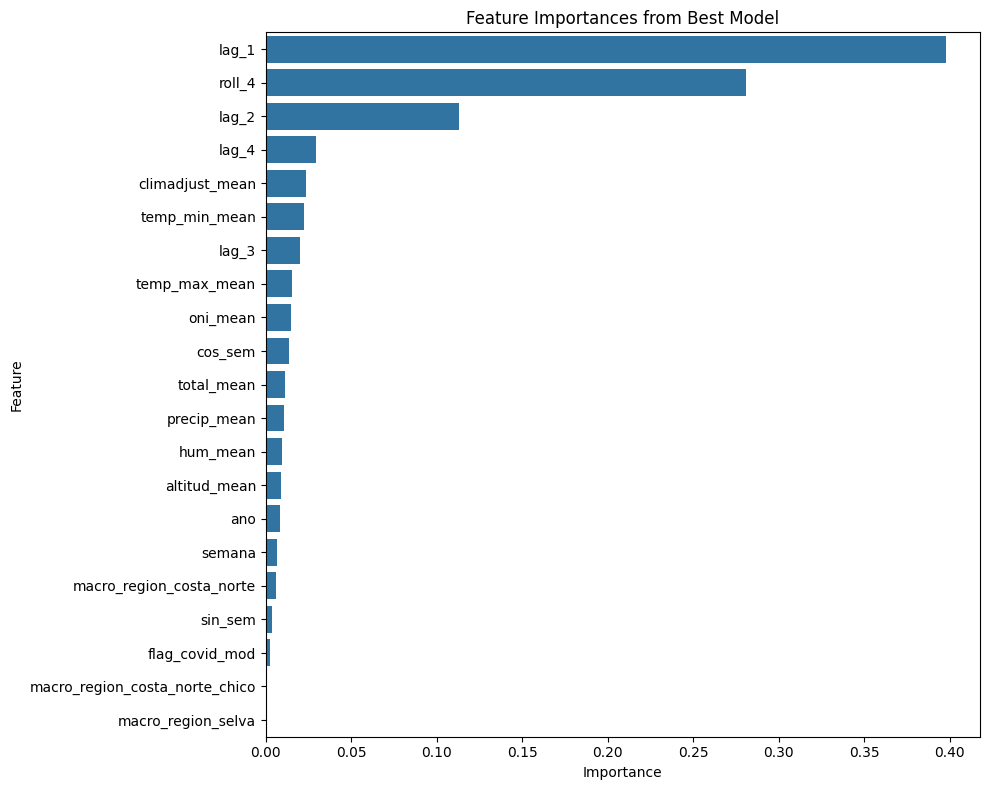

In [ ]:
# Get the fitted model from the pipeline
fitted_model = best_pipeline.named_steps['model']
# Get the fitted preprocessor from the pipeline
fitted_preprocessor = best_pipeline.named_steps['prep']


# Get feature importances
if hasattr(fitted_model, 'feature_importances_'):
    importances = fitted_model.feature_importances_
elif hasattr(fitted_model, 'coef_'):
    # For linear models (like Lasso or Ridge), use coefficients as a measure of importance
    importances = fitted_model.coef_
    # For Lasso, coef_ can be sparse, convert to dense array
    if isinstance(importances, np.sparse.ndarray):
        importances = importances.toarray().flatten()
else:
    print("The best model does not have feature importances or coefficients.")
    importances = None

if importances is not None:
    # Get feature names after preprocessing
    # Get numerical feature names
    num_feature_names = num_feats
    # Get categorical feature names after one-hot encoding from the fitted preprocessor
    cat_feature_names = list(fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(cat_feats))

    # Combine all feature names
    feature_names = num_feature_names + cat_feature_names


    # Create a DataFrame for better visualization
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort by importance
    feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

    # Display the feature importances
    print("Feature Importances:")
    display(feature_importances_df)

    # Optional: Plot feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
    plt.title('Feature Importances from Best Model')
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Feature Engineering ===
df['sin_sem'] = np.sin(2*np.pi*df['semana']/52)
df['cos_sem'] = np.cos(2*np.pi*df['semana']/52)
for lag in range(1,5):
    df[f'lag_{lag}'] = df['total_casos'].shift(lag)
df['roll_4'] = df['total_casos'].rolling(4).mean()
df = df.dropna().reset_index(drop=True)

num_feats = [
    'ano','semana','sin_sem','cos_sem',
    'precip_mean','temp_max_mean','temp_min_mean','hum_mean','altitud_mean',
    'lag_1','lag_2','lag_3','lag_4','roll_4','flag_covid_mod' ,'oni_mean',
'total_mean','climadjust_mean'
]
cat_feats = ['macro_region']

avail = df[(df['ano']<2023) | ((df['ano']==2023)&(df['semana']<=39))]
hold  = df[(df['ano']==2023)&(df['semana']>=40)]
X_av,   y_av   = avail[num_feats+cat_feats], avail['total_casos']
X_hold, y_hold = hold [num_feats+cat_feats], hold ['total_casos']
X_train, X_test, y_train, y_test = train_test_split(X_av, y_av, test_size=0.30, shuffle=False)

# === Preprocessing ===
pre = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

tscv = TimeSeriesSplit(n_splits=5)

def fit_search(name, base_model, param_dist=None, n_iter=20):
    pipe = Pipeline([('prep', pre), ('model', base_model)])
    if param_dist:
        rs = RandomizedSearchCV(
            pipe, param_distributions=param_dist, n_iter=n_iter,
            cv=tscv, scoring='neg_root_mean_squared_error',
            random_state=7, n_jobs=-1
        )
        rs.fit(X_train, y_train)
        best = rs.best_estimator_
        best_params = rs.best_params_
    else:
        best = pipe.fit(X_train, y_train)
        best_params = {}

    def eval_block(X, y):
        p = best.predict(X)
        # Calculate overall metrics
        overall_rmse = np.sqrt(mean_squared_error(y, p))
        overall_mae = mean_absolute_error(y, p)
        overall_r2 = r2_score(y, p)

        # Calculate regional metrics
        regional_metrics = {}
        X_evaluated = X.copy()
        X_evaluated['actual'] = y
        X_evaluated['predicted'] = p

        for region, g in X_evaluated.groupby('macro_region'):
            regional_metrics[region] = {
                'rmse': np.sqrt(mean_squared_error(g['actual'], g['predicted'])),
                'mae': mean_absolute_error(g['actual'], g['predicted']),
                'r2': r2_score(g['actual'], g['predicted'])
            }

        return {
            'overall': {'rmse': overall_rmse, 'mae': overall_mae, 'r2': overall_r2},
            'regional': regional_metrics
        }


    test_m = eval_block(X_test,  y_test)
    hold_m = eval_block(X_hold, y_hold)
    return {
        'modelo': name,
        'best_params': best_params,
        'test_metrics': test_m,
        'hold_metrics': hold_m,
        'estimator': best
    }

results = []

# ‚Äî Lineales y KNN (sin Linear directo) ‚Äî
results.append(fit_search('Ridge', Ridge(random_state=7), {'model__alpha': [0.1,1.0,10.0]}, n_iter=10))
results.append(fit_search('Lasso', Lasso(random_state=7), {'model__alpha': [0.001,0.01,0.1,1.0]}, n_iter=10))
results.append(fit_search('KNN', KNeighborsRegressor(), {'model__n_neighbors': [3,5,7,9]}, n_iter=10))

# ‚Äî Consolidar resultados (sin Linear) ‚Äî
# Consolidate overall results
res_df_overall = pd.DataFrame([{
    'modelo':    r['modelo'],
    'rmse_test': r['test_metrics']['overall']['rmse'],
    'r2_test':   r['test_metrics']['overall']['r2'],
    'mae_test':  r['test_metrics']['overall']['mae'],
    'rmse_hold': r['hold_metrics']['overall']['rmse'],
    'r2_hold':   r['hold_metrics']['overall']['r2'],
    'mae_hold':  r['hold_metrics']['overall']['mae']
} for r in results]).sort_values('rmse_hold')

print("Overall Metrics on Hold-out Set:")
print(res_df_overall.to_string(index=False))

best_name_overall = res_df_overall.iloc[0]['modelo']
print(f"\nBest Model Overall on HOLD: {best_name_overall}")

# Consolidate regional results for the hold-out set
regional_results_list = []
for r in results:
    model_name = r['modelo']
    for region, metrics in r['hold_metrics']['regional'].items():
        regional_results_list.append({
            'modelo': model_name,
            'macro_region': region,
            'rmse_hold': metrics['rmse'],
            'mae_hold': metrics['mae'],
            'r2_hold': metrics['r2']
        })

res_df_regional = pd.DataFrame(regional_results_list)

print("\nRegional Metrics on Hold-out Set:")
# Pivot the table for better readability
res_df_regional_pivot = res_df_regional.pivot_table(
    index='modelo',
    columns='macro_region',
    values=['rmse_hold', 'mae_hold', 'r2_hold']
)
print(res_df_regional_pivot.to_string())

best_row = res_df_overall.iloc[0]
print("\nMejor en HOLD:", best_row['modelo'])
best_lineal = [r for r in results if r['modelo']==best_row['modelo']][0]['estimator']
print("Best params:", [r for r in results if r['modelo']==best_row['modelo']][0]['best_params'])

Overall Metrics on Hold-out Set:
modelo  rmse_test   r2_test   mae_test  rmse_hold   r2_hold  mae_hold
 Lasso   0.874105  0.999933   0.665739   0.635006  0.999938  0.492379
 Ridge   5.321029  0.997509   4.299040   5.036315  0.996119  3.793293
   KNN 138.128427 -0.678549 109.310559  87.348469 -0.167381 69.829060

Best Model Overall on HOLD: Lasso

Regional Metrics on Hold-out Set:
                mae_hold                                   r2_hold                                rmse_hold                              
macro_region costa_norte costa_norte_chico       selva costa_norte costa_norte_chico      selva costa_norte costa_norte_chico       selva
modelo                                                                                                                                   
KNN            77.743590         13.307692  118.435897   -0.594378        -27.727357 -11.898494   86.321403         13.561824  123.506912
Lasso           0.653026          0.211219    0.612890    0.99985

In [ ]:
# 1. Obtener el modelo final (sin preprocesador)
best_model = best_lineal.named_steps['model']

# 2. Obtener el nombre de columnas procesadas
# Access the fitted transformers using the correct attribute
ohe = best_lineal.named_steps['prep'].named_transformers_['cat']
cat_ohe_cols = list(ohe.get_feature_names_out(cat_feats))
all_feats = num_feats + cat_ohe_cols

# 3. Obtener los coeficientes y ordenarlos
coefs = pd.Series(best_model.coef_, index=all_feats)
coefs_sorted = coefs.abs().sort_values(ascending=False)

# Mostrar las 10 variables m√°s influyentes
print("\nTop 10 variables m√°s influyentes en el modelo:", best_row['modelo'])
print(coefs_sorted.head(10))


Top 10 variables m√°s influyentes en el modelo: Lasso
roll_4                989.470848
lag_3                 253.490930
lag_2                 251.463909
lag_1                 247.914762
ano                     0.256438
temp_min_mean           0.235225
macro_region_selva      0.074656
altitud_mean            0.074634
climadjust_mean         0.068195
cos_sem                 0.041881
dtype: float64


In [ ]:
hold

macro_region   ano  semana  total_casos  precip_mean  temp_max_mean  \
208        costa_norte  2023      40          344     0.220346      28.949089   
209        costa_norte  2023      41          227     0.288168      28.133301   
210        costa_norte  2023      42          237     0.000123      29.705687   
211        costa_norte  2023      43          193     0.117494      28.381012   
212        costa_norte  2023      44          155     0.000000      28.520049   
213        costa_norte  2023      45          169     0.000000      28.303061   
214        costa_norte  2023      46          120   -11.058873      27.260643   
215        costa_norte  2023      47          120     0.000000      28.717310   
216        costa_norte  2023      48          152     0.000294      29.253339   
217        costa_norte  2023      49          127     0.026029      28.444574   
218        costa_norte  2023      50          117     0.133292      30.046700   
219        costa_norte  2023      51          101     0.082216      29.344010   
220        costa_norte  2023      52           83     1.478928      28.969553   
265  costa_norte_chico  2023      40           17     0.000000      23.022941   
266  costa_norte_chico  2023      41           11     0.000000      23.885714   
267  costa_norte_chico  2023      42           11     0.000000      19.871429   
268  costa_norte_chico  2023      43           12     0.000000      21.790238   
269  costa_norte_chico  2023      44           12     0.005208      22.788315   
270  costa_norte_chico  2023      45           11     0.000000      23.030563   
271  costa_norte_chico  2023      46            8     0.000000      21.180150   
272  costa_norte_chico  2023      47           16     0.000000      22.650682   
273  costa_norte_chico  2023      48           11     0.000000      23.811299   
274  costa_norte_chico  2023      49           13     0.000000      18.205055   
275  costa_norte_chico  2023      50           16     0.000000      20.801040   
276  costa_norte_chico  2023      51           14     0.004082      21.821633   
277  costa_norte_chico  2023      52           10     0.135625      23.479750   
578              selva  2023      40           72    -3.271639      33.174268   
579              selva  2023      41          118     2.585979      28.945607   
580              selva  2023      42          111     2.605600      29.076157   
581              selva  2023      43           99    -1.737619      29.924682   
582              selva  2023      44          144    -2.910992      26.963927   
583              selva  2023      45          199    -6.074594      29.053624   
584              selva  2023      46          177    -6.011142      28.858803   
585              selva  2023      47          179     7.748135      27.490833   
586              selva  2023      48          149     0.410225      27.888762   
587              selva  2023      49          152    -9.508708      28.569423   
588              selva  2023      50          164    -0.341685      26.612448   
589              selva  2023      51          156    -1.464474      28.267472   
590              selva  2023      52          165     2.761474      26.470642   

     temp_min_mean   hum_mean  oni_mean  climadjust_mean  total_mean  \
208      20.048098  79.647920      1.72            26.72       28.44   
209      19.620053  80.683213      1.72            26.72       28.44   
210      20.149822  78.789101      1.72            26.72       28.44   
211      19.563159  79.125499      1.72            26.72       28.44   
212      18.467211  79.223345      1.72            26.72       28.44   
213      18.537100  78.642857      2.02            26.70       28.72   
214      18.268310  78.901871      2.02            26.70       28.72   
215      18.521476  75.417857      2.02            26.70       28.72   
216      18.815585  76.096773      2.02            26.70       28.72   
217      18.721282  77.017433      2.02          

In [ ]:
# ================== PREDICCI√ìN 2024 SIN RE-ENTRENAR ==================
import pandas as pd, numpy as np
from scipy.stats import mode

RUTA_2024 = "https://raw.githubusercontent.com/galuf/dengueML/refs/heads/main/2024/2024_final.csv"     # <-- cambia si es otra ruta
SALIDA    = "predicciones_2024_arbol.csv"

# columnas m√≠nimas requeridas en el CSV 2024 (excluding total_casos as we'll predict it)
req_cols = {
    'ano','semana',
    'precip_mean','temp_max_mean','temp_min_mean','hum_mean','macro_region','flag_covid_mod',
    'oni_mean','total_mean','climadjust_mean'
}
df2024 = pd.read_csv(RUTA_2024, sep=',')

df2024.columns = [c.strip() for c in df2024.columns]

faltan = sorted(list(req_cols - set(df2024.columns)))
if faltan:
    raise ValueError(f"Al CSV 2024 le faltan columnas: {faltan}")

# Impute 'altitud_mean' if missing or not in original data
if 'altitud_mean' not in df2024.columns and 'altitud_mean' in num_feats:
    # Calculate median altitude from the original training data for imputation
    if 'altitud_mean' in df_macro_sem_dengue.columns:
        med_map = df_macro_sem_dengue.groupby('macro_region')['altitud_mean'].median().to_dict()
        df2024['altitud_mean'] = df2024['macro_region'].map(med_map)
        df2024['altitud_mean'] = df2024['altitud_mean'].fillna(df_macro_sem_dengue['altitud_mean'].median())
    else:
        # If 'altitud_mean' was in num_feats but not in the original training data, fill with median from df_macro_sem_dengue
        df2024['altitud_mean'] = df_macro_sem_dengue['altitud_mean'].median()
elif 'altitud_mean' not in df2024.columns and 'altitud_mean' not in num_feats:
    # If altitud_mean is not in num_feats, it's not needed for prediction, do nothing
    pass
elif 'altitud_mean' in df2024.columns and 'altitud_mean' not in num_feats:
     # If altitud_mean is in df2024 but not in num_feats, it's not needed for prediction, drop it
     df2024 = df2024.drop(columns=['altitud_mean'])


# Impute 'flag_covid_mod' using the mode of 'flag_covid' from the original data by 'macro_region'
if 'flag_covid_mod' not in df2024.columns and 'flag_covid' in df_dengue_anl.columns:
    # Calculate the mode of flag_covid for each macro_region from the combined dengue and covid data
    mode_map = df_dengue_anl.groupby('macro_region')['flag_covid'].apply(lambda x: mode(x, keepdims=True).mode[0]).to_dict()
    df2024['flag_covid_mod'] = df2024['macro_region'].map(mode_map)
    # Fill any remaining NaNs (if a macro_region in df2024 wasn't in df_dengue_anl) with the overall mode or 0
    df2024['flag_covid_mod'] = df2024['flag_covid_mod'].fillna(mode(df_dengue_anl['flag_covid'], keepdims=True).mode[0])
elif 'flag_covid_mod' not in df2024.columns:
     # If flag_covid was not in df_dengue_anl, fill with 0
     df2024['flag_covid_mod'] = 0.0


# Ensure same type
df2024['macro_region'] = df2024['macro_region'].astype(str)
#df2024 =df2024[df2024['macro_region']!='otras']
# For constructing lags correctly, concatenate training (<=2023) + 2024

# Define cols_base_train based on df_macro_sem_dengue
cols_base_train = [col for col in df_macro_sem_dengue.columns if col in num_feats + cat_feats + ['total_casos']]

# Select only the necessary columns from df_macro_sem_dengue for concatenation
df_train_base = df_macro_sem_dengue[cols_base_train].copy()


# Prepare df_2024_base with required columns for merging and feature engineering
cols_base_2024 = [
    'macro_region','ano','semana',
    'precip_mean','temp_max_mean','temp_min_mean','hum_mean','flag_covid_mod', # Include flag_covid_mod here
    'oni_mean','total_mean','climadjust_mean'
]
if 'altitud_mean' in df2024.columns:
    cols_base_2024.append('altitud_mean')

df_2024_base  = df2024[cols_base_2024].copy()
# Add 'total_casos' column to df_2024_base and set to NaN for concatenation
df_2024_base['total_casos'] = np.nan

df_all = pd.concat([hold, df_2024_base], ignore_index=True)
df_all = df_all.sort_values(['macro_region','ano','semana']).reset_index(drop=True)
print(df_all)
# 2. Agregar variables c√≠clicas una vez
df_all['sin_sem'] = np.sin(2 * np.pi * df_all['semana'] / 52.0)
df_all['cos_sem'] = np.cos(2 * np.pi * df_all['semana'] / 52.0)

# 3. Inicializar resultado
predicciones = []

# 4. Iterar por macro_regi√≥n
for region, df_region in df_all.groupby('macro_region'):
    df_region = df_region.copy().reset_index(drop=True)

    # 4.1 Obtener semanas de predicci√≥n
    idx_2024 = (df_region['ano'] == 2024) & (df_region['semana'] <= 52)
    semanas_pred = df_region[idx_2024].index.tolist()
    # 4.2 Generar lags/roll y predecir semana a semana
    for idx in semanas_pred:
        # Generar lags y roll a partir de semanas anteriores
        prev_vals = df_region.loc[:idx - 1, 'total_casos'].tolist()

        for l in range(1, 5):
            lag_name = f'lag_{l}'
            if len(prev_vals) >= l:
                df_region.at[idx, lag_name] = prev_vals[-l]
            else:
                df_region.at[idx, lag_name] = np.nan

        # Rolling 4
        if len(prev_vals) >= 4:
            df_region.at[idx, 'roll_4'] = np.mean(prev_vals[-4:])
        else:
            df_region.at[idx, 'roll_4'] = np.nan

        # Verifica si tienes todos los features
        if df_region.loc[idx, num_feats + cat_feats].isnull().any():
            continue  # skip si faltan lags

        # Extraer features
        X_pred = df_region.loc[[idx], num_feats + cat_feats]

        # Predecir
        y_hat = int(round(max(0, best_pipeline.predict(X_pred)[0])))

        df_region.at[idx, 'total_casos'] = y_hat

        # Guardar resultado
        predicciones.append({
            'ano': df_region.at[idx, 'ano'],
            'semana': df_region.at[idx, 'semana'],
            'macro_region': region,
            'y_pred': y_hat
        })

# 5. Guardar resultados
df_preds_tree = pd.DataFrame(predicciones)
df_preds_tree = df_preds_tree[df_preds_tree['ano'] != 2025 ]
df_preds_tree.to_csv(SALIDA, index=False)
print("Guardado:", SALIDA)

    macro_region   ano  semana  total_casos  precip_mean  temp_max_mean  \
0    costa_norte  2023      40        344.0     0.220346      28.949089   
1    costa_norte  2023      41        227.0     0.288168      28.133301   
2    costa_norte  2023      42        237.0     0.000123      29.705687   
3    costa_norte  2023      43        193.0     0.117494      28.381012   
4    costa_norte  2023      44        155.0     0.000000      28.520049   
..           ...   ...     ...          ...          ...            ...   
190        selva  2024      48          NaN     3.723643      20.092484   
191        selva  2024      49          NaN     2.211462      20.018221   
192        selva  2024      50          NaN     7.346304      19.647783   
193        selva  2024      51          NaN     9.019844      19.997903   
194        selva  2024      52          NaN     6.883137      20.170891   

     temp_min_mean   hum_mean  oni_mean  climadjust_mean  total_mean  \
0        20.048098  79.6479

In [ ]:
df_preds_tree.ano.value_counts()

ano
2024    156
Name: count, dtype: int64

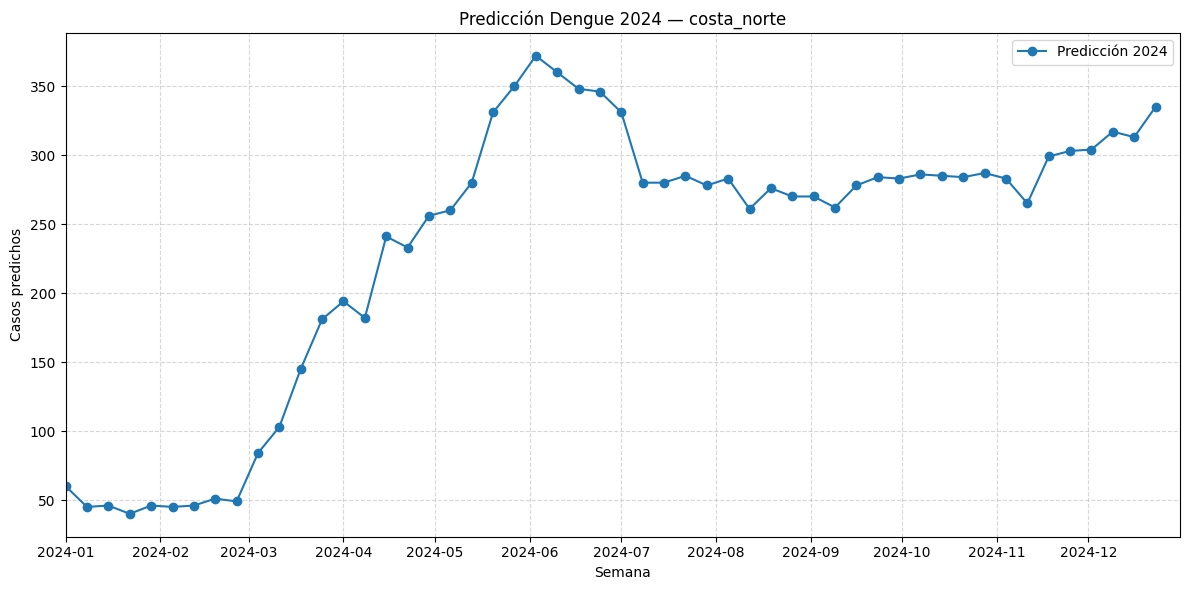

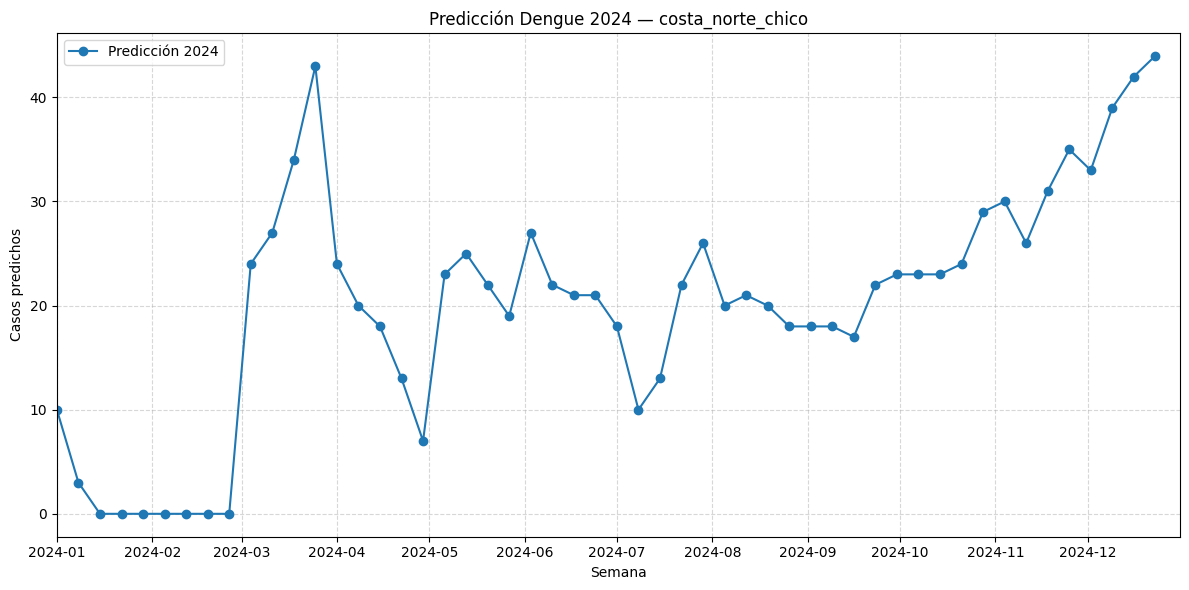

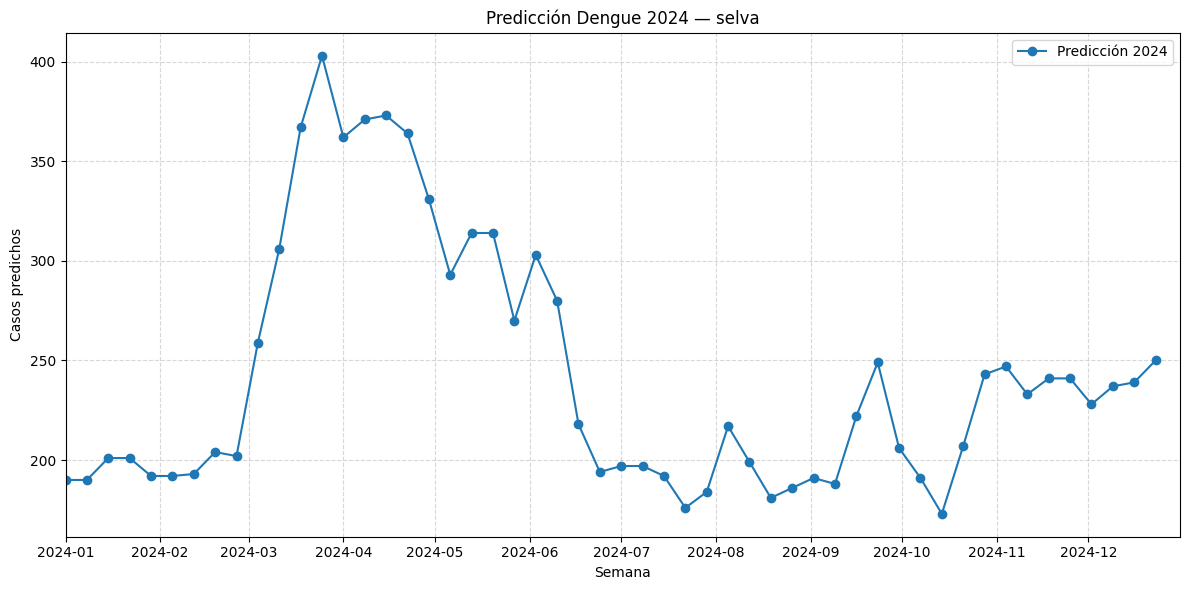

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Generar fecha aproximada del inicio de semana ISO
df_preds_tree['week_start'] = pd.to_datetime(df_preds_tree['ano'].astype(str) + '-W' + df_preds_tree['semana'].astype(str).str.zfill(2) + '-1', format='%G-W%V-%u')
df_preds_tree = df_preds_tree[df_preds_tree['week_start'].dt.year == 2024]

# Ordenar por fecha por si acaso
df_preds_tree = df_preds_tree.sort_values(['macro_region', 'week_start'])

# Gr√°fico por macro regi√≥n
for mr, g in df_preds_tree.groupby('macro_region'):
    plt.figure(figsize=(12, 6))
    plt.plot(g['week_start'], g['y_pred'], marker='o', label='Predicci√≥n 2024')
    plt.title(f'Predicci√≥n Dengue 2024 ‚Äî {mr}')
    plt.xlabel('Semana')
    plt.ylabel('Casos predichos')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-12-31'))  # üí• Esto es lo que faltaba
    plt.tight_layout()
    plt.show()



In [ ]:
# ================== PREDICCI√ìN 2024 SIN RE-ENTRENAR ==================
import pandas as pd, numpy as np
from scipy.stats import mode
from IPython.display import display # Import display

RUTA_2024 = "https://raw.githubusercontent.com/galuf/dengueML/refs/heads/main/2024/2024_final.csv"     # <-- cambia si es otra ruta
SALIDA = "predicciones_2024_lasso.csv"

# columnas m√≠nimas requeridas in the CSV 2024 (excluding total_casos as we'll predict it)
req_cols = {
    'ano','semana',
    'precip_mean','temp_max_mean','temp_min_mean','hum_mean','macro_region','flag_covid_mod',
    'oni_mean','total_mean','climadjust_mean'
}
df2024 = pd.read_csv(RUTA_2024, sep=',')

df2024.columns = [c.strip() for c in df2024.columns]

faltan = sorted(list(req_cols - set(df2024.columns)))
if faltan:
    raise ValueError(f"Al CSV 2024 le faltan columnas: {faltan}")

# Impute 'altitud_mean' if missing or not in original data
if 'altitud_mean' not in df2024.columns and 'altitud_mean' in num_feats:
    # Calculate median altitude from the original training data for imputation
    if 'altitud_mean' in df_macro_sem_dengue.columns:
        med_map = df_macro_sem_dengue.groupby('macro_region')['altitud_mean'].median().to_dict()
        df2024['altitud_mean'] = df2024['macro_region'].map(med_map)
        df2024['altitud_mean'] = df2024['altitud_mean'].fillna(df_macro_sem_dengue['altitud_mean'].median())
    else:
        # If 'altitud_mean' was in num_feats but not in the original training data, fill with median from df_macro_sem_dengue
        df2024['altitud_mean'] = df_macro_sem_dengue['altitud_mean'].median()
elif 'altitud_mean' not in df2024.columns and 'altitud_mean' not in num_feats:
    # If altitud_mean is not in num_feats, it's not needed for prediction, do nothing
    pass
elif 'altitud_mean' in df2024.columns and 'altitud_mean' not in num_feats:
     # If altitud_mean is in df2024 but not in num_feats, it's not needed for prediction, drop it
     df2024 = df2024.drop(columns=['altitud_mean'])


# Impute 'flag_covid_mod' using the mode of 'flag_covid' from the original data by 'macro_region'
if 'flag_covid_mod' not in df2024.columns and 'flag_covid' in df_dengue_anl.columns:
    # Calculate the mode of flag_covid for each macro_region from the combined dengue and covid data
    mode_map = df_dengue_anl.groupby('macro_region')['flag_covid'].apply(lambda x: mode(x, keepdims=True).mode[0]).to_dict()
    df2024['flag_covid_mod'] = df2024['macro_region'].map(mode_map)
    # Fill any remaining NaNs (if a macro_region in df2024 wasn't in df_dengue_anl) with the overall mode or 0
    df2024['flag_covid_mod'] = df2024['flag_covid_mod'].fillna(mode(df_dengue_anl['flag_covid'], keepdims=True).mode[0])
elif 'flag_covid_mod' not in df2024.columns:
     # If flag_covid was not in df_dengue_anl, fill with 0
     df2024['flag_covid_mod'] = 0.0


# Ensure same type
df2024['macro_region'] = df2024['macro_region'].astype(str)
#df2024 =df2024[df2024['macro_region']!='otras']
# For constructing lags correctly, concatenate training (<=2023) + 2024

# Define columns needed from df_macro_sem_dengue for concatenation (excluding lags, roll_4, sin_sem, cos_sem)
cols_for_concat_2023 = [col for col in df_macro_sem_dengue.columns if col in ['macro_region','ano','semana','total_casos',
                                                                           'precip_mean','temp_max_mean','temp_min_mean','hum_mean','altitud_mean','flag_covid_mod',]]


# Select the last 4 weeks of 2023 data from df_macro_sem_dengue per macro_region for initial lag/roll calculation
df_2023_tail = df_macro_sem_dengue[df_macro_sem_dengue['ano'] == 2023].groupby('macro_region').tail(4)[cols_for_concat_2023].copy()


# Prepare df_2024_base with required columns for merging and feature engineering
cols_base_2024 = [
    'macro_region','ano','semana',
    'precip_mean','temp_max_mean','temp_min_mean','hum_mean','flag_covid_mod' # Include flag_covid_mod here
   ,'oni_mean','total_mean','climadjust_mean'
    ]
if 'altitud_mean' in df2024.columns:
    cols_base_2024.append('altitud_mean')

df_2024_base  = df2024[cols_base_2024].copy()
# Add 'total_casos' column to df_2024_base and set to NaN for concatenation
df_2024_base['total_casos'] = np.nan


# Concatenate the last 4 weeks of 2023 data with the 2024 data
df_all = pd.concat([df_2023_tail, df_2024_base], ignore_index=True)
df_all = df_all.sort_values(['macro_region','ano','semana']).reset_index(drop=True)

# Feature engineering and prediction week by week for 2024 data
predicciones = []

# Iterate by macro_region
for region, df_region in df_all.groupby('macro_region'):
    df_region = df_region.copy().reset_index(drop=True)

    # Ensure cyclic features are added for each macro_region group
    df_region['sin_sem'] = np.sin(2*np.pi*df_region['semana']/52.0)
    df_region['cos_sem'] = np.cos(2*np.pi*df_region['semana']/52.0)


    # Identify the index where 2024 data starts
    start_2024_idx = df_region[df_region['ano'] == 2024].index.min()

    # Iterate through 2024 weeks for this macro_region
    for idx in df_region[df_region['ano'] == 2024].index:
        # Calculate lags and rolling mean based on available data (actual from 2023 or predicted from 2024)
        # Ensure we have enough data points from previous weeks for lags and rolling mean
        if idx >= start_2024_idx: # Only calculate lags/roll for 2024 data
             # Get previous data points for lag and rolling mean calculation
            prev_data = df_region.loc[:idx - 1, 'total_casos'].tolist()

            # Calculate lags
            for l in range(1, 5):
                lag_name = f'lag_{l}'
                if len(prev_data) >= l:
                    df_region.at[idx, lag_name] = prev_data[-l]
                else:
                    df_region.at[idx, lag_name] = np.nan # Should ideally not happen if we use enough 2023 tail data

            # Calculate Rolling 4
            if len(prev_data) >= 4:
                df_region.at[idx, 'roll_4'] = np.mean(prev_data[-4:])
            else:
                df_region.at[idx, 'roll_4'] = np.nan # Should ideally not happen


        # Prepare features for prediction for the current week
        # Ensure all columns in num_feats and cat_feats are present in df_region before selecting
        all_required_cols_for_X = num_feats + cat_feats
        missing_cols_in_df_region = list(set(all_required_cols_for_X) - set(df_region.columns))
        if missing_cols_in_df_region:
            print(f"Skipping prediction for {region}, A√±o: {df_region.at[idx, 'ano']}, Semana: {df_region.at[idx, 'semana']} due to missing required feature columns: {missing_cols_in_df_region}")
            continue


        X_pred_week = df_region.loc[[idx], all_required_cols_for_X]

        # Check if any required feature is missing before predicting
        if X_pred_week.isnull().any(axis=1).iloc[0]:
             # If features are missing (e.g., not enough historical data), skip prediction for this row
             print(f"Skipping prediction for {region}, A√±o: {df_region.at[idx, 'ano']}, Semana: {df_region.at[idx, 'semana']} due to missing features.")
             continue


        # Predecir using the trained pipeline
        y_hat = int(round(max(0, best_lineal.predict(X_pred_week)[0])))

        # Store the predicted value in the DataFrame for the current week
        df_region.at[idx, 'total_casos'] = y_hat

        # Save the result
        predicciones.append({
            'ano': df_region.at[idx, 'ano'],
            'semana': df_region.at[idx, 'semana'],
            'macro_region': region,
            'y_pred': y_hat
        })

# Create the final predictions DataFrame
df_preds_lineal = pd.DataFrame(predicciones)


df_preds_lineal.to_csv(SALIDA, index=False)
print("Guardado:", SALIDA)

# Display last few rows of df_preds to check for 2025 data
# print("\nLast few rows of df_preds:")
# display(df_preds.tail()) # Commented out display as per user's implicit preference

Guardado: predicciones_2024_lasso.csv


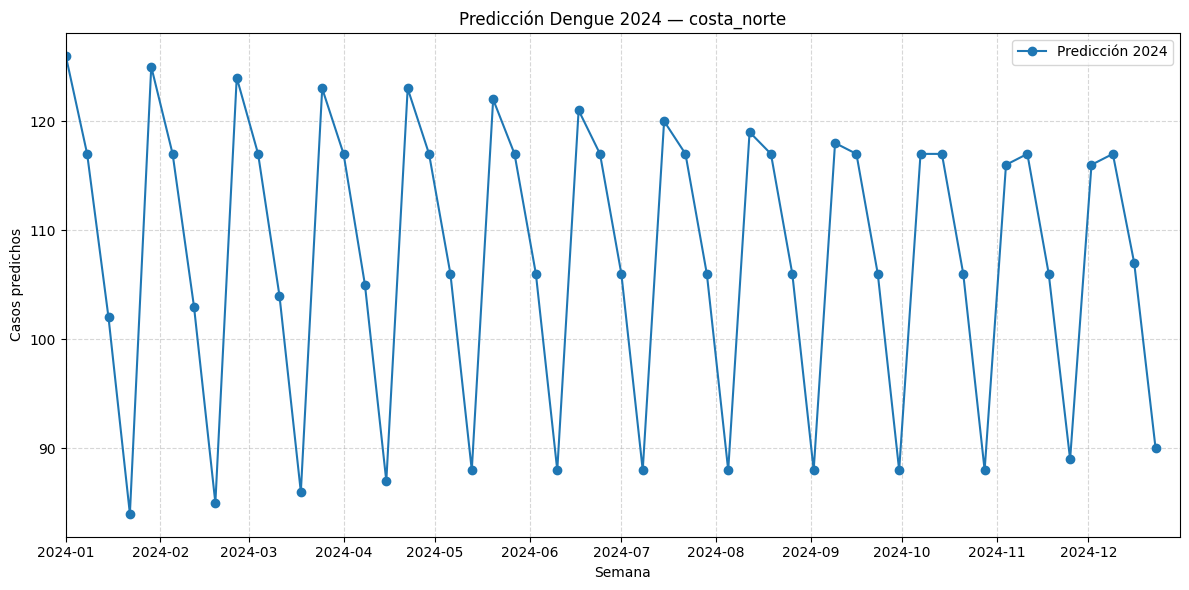

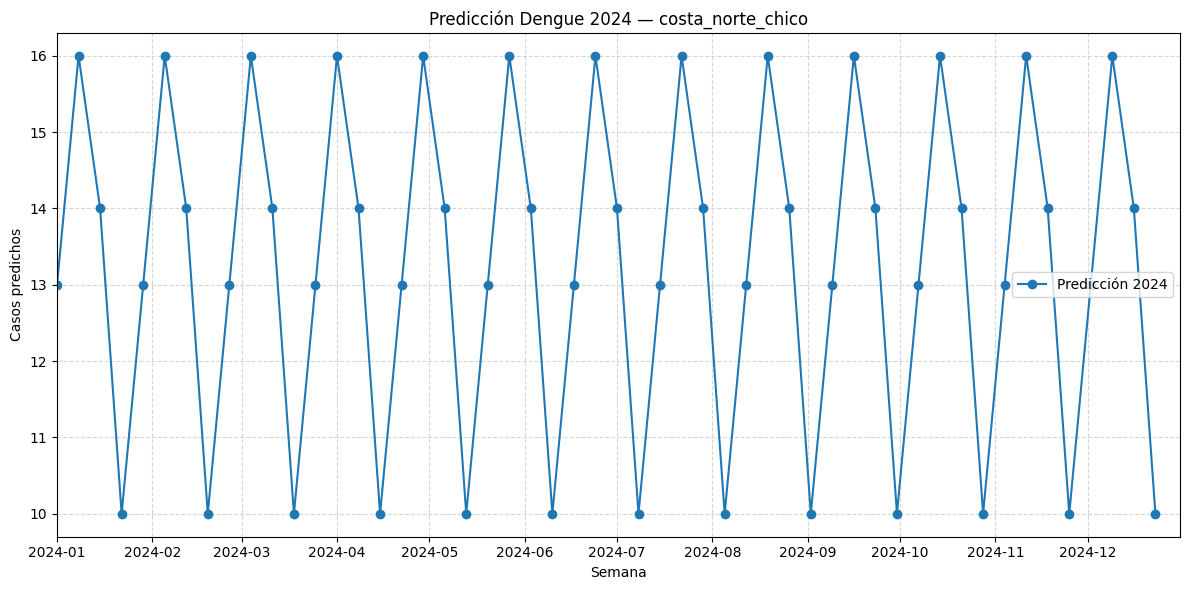

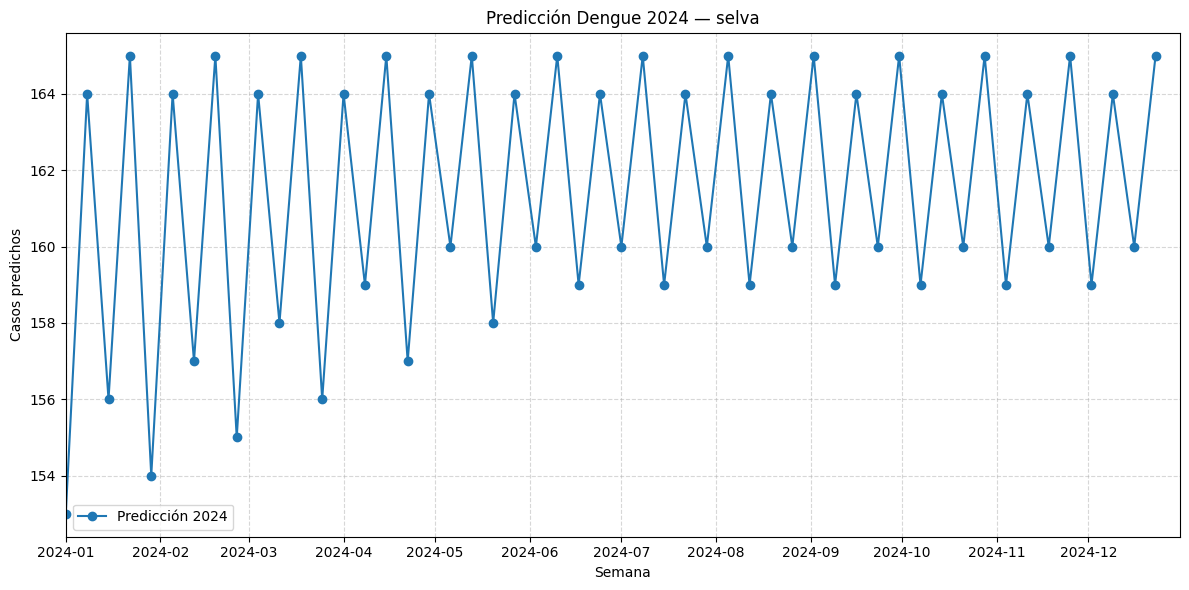

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Generar fecha aproximada del inicio de semana ISO
df_preds_lineal['week_start'] = pd.to_datetime(df_preds_lineal['ano'].astype(str) + '-W' + df_preds_lineal['semana'].astype(str).str.zfill(2) + '-1', format='%G-W%V-%u')
df_preds_lineal = df_preds_lineal[df_preds_lineal['week_start'].dt.year == 2024]

# Ordenar por fecha por si acaso
df_preds_lineal = df_preds_lineal.sort_values(['macro_region', 'week_start'])

# Gr√°fico por macro regi√≥n
for mr, g in df_preds_lineal.groupby('macro_region'):
    plt.figure(figsize=(12, 6))
    plt.plot(g['week_start'], g['y_pred'], marker='o', label='Predicci√≥n 2024')
    plt.title(f'Predicci√≥n Dengue 2024 ‚Äî {mr}')
    plt.xlabel('Semana')
    plt.ylabel('Casos predichos')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-12-31'))
    plt.tight_layout()
    plt.show()



In [ ]:
# Obtener el mejor pipeline (ejemplo: si fue 'XGB_custom')
best_pipeline = next(r['estimator'] for r in results if r['modelo'] == best_name_overall)

# Acceder al ColumnTransformer (etapa 'prep' del pipeline)
preprocessor = best_pipeline.named_steps['prep']  # <- Esto es tu ColumnTransformer

In [ ]:
# Aplicar transformaci√≥n a tus datos (ejemplo: X_train)
X_transformed = preprocessor.transform(X_train)  # Matriz transformada completa (num + cat)

# Obtener las partes separadas (num√©ricas y categ√≥ricas)
X_num_transformed = preprocessor.named_transformers_['num'].transform(X_train[num_feats])
X_cat_transformed = preprocessor.named_transformers_['cat'].transform(X_train[cat_feats])

# Si quieres los nombres de las caracter√≠sticas categ√≥ricas despu√©s del OneHot
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(cat_feats)

In [ ]:
import pandas as pd

# Datos num√©ricos escalados (con nombres de columnas)
df_num_transformed = pd.DataFrame(
    X_num_transformed,
    columns=num_feats,
    index=X_train.index
)

# Datos categ√≥ricos codificados (con nombres de columnas)
df_cat_transformed = pd.DataFrame(
    X_cat_transformed.toarray(),  # OneHot devuelve una matriz sparse por defecto
    columns=cat_feature_names,
    index=X_train.index
)

# Combinar ambos
df_transformed = pd.concat([df_num_transformed, df_cat_transformed], axis=1)
print(df_transformed.head())

        ano    semana   sin_sem   cos_sem  precip_mean  temp_max_mean  \
0 -0.854247 -1.055096  1.127658  0.714248     0.003460       0.805085   
1 -0.854247 -0.986345  1.198180  0.557892     0.004399       0.446438   
2 -0.854247 -0.917594  1.249300  0.394194     0.059798       0.404244   
3 -0.854247 -0.642591  1.249300 -0.285411     0.006277       0.420067   
4 -0.854247 -0.573840  1.198180 -0.449109     0.098765       0.485994   

   temp_min_mean  hum_mean  altitud_mean     lag_1  ...     lag_3     lag_4  \
0       1.107584 -0.933074     -0.754574 -0.529345  ... -0.523018 -0.519649   
1       1.143498 -0.603343     -0.754574 -0.529345  ... -0.523018 -0.519649   
2       1.157863 -0.706275     -0.754574 -0.517711  ... -0.523018 -0.519649   
3       1.236872 -0.418415     -0.754574 -0.521589  ... -0.523018 -0.519649   
4       0.934302 -0.383959     -0.577210 -0.521589  ... -0.511346 -0.519649   

     roll_4  flag_covid_mod  oni_mean  total_mean  climadjust_mean  \
0 -0.539058     